In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

pd.set_option('display.max_columns', None)
from collections import Counter
from wordcloud import WordCloud
%matplotlib inline
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
# from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings('ignore')

# ***Data Preprocessing***

#### **Reading the Data**

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("Shape of train data : ", train.shape)
print("Shape of test data : ", test.shape)
train.head(2)

Shape of train data :  (3000, 23)
Shape of test data :  (4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [3]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

#### **Converting the data stored in string into dictionaries** 

In [5]:
string_columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df, columns = string_columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = text_to_dict(train)
test = text_to_dict(test)

#### **Processing each column individually** 
1) Belongs_to_collection

In [6]:
train['belongs_to_collection'][:3]

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
Name: belongs_to_collection, dtype: object

In [7]:
train['belongs_to_collection'].apply(lambda x: len(x) if x!={} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [8]:
train['collection'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!={} else 0)
train['has_collection'] = train['collection'].apply(lambda x: 1 if x!=0 else 0)

test['collection'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!={} else 0)
test['has_collection'] = test['collection'].apply(lambda x: 1 if x!=0 else 0)

train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

**Creating one function to process all the data in different columns**

In [9]:
def create_new_columns(df, col_name, new_col_prefix, top_n, plot=False,stat=False,stat_p=False,vals=False):
    df['num_'+col_name] = df[col_name].apply(lambda x: len(x) if x!={} else 0)
    list_of_vals = df[col_name].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
    df['all_'+col_name] = df[col_name].apply(lambda x : ' '.join( i['name'] for i in x ) if x!={} else "" )
    top_vals = [m[0] for m in Counter(i for j in list_of_vals for i in j).most_common(top_n)]
    for val in top_vals:
        df[new_col_prefix + val] = df['all_'+col_name].apply(lambda x:1 if val in x else 0)
    
    if stat:
        if vals==True:
            print(train[col_name].apply(lambda x: len(x) if x!={} else 0).value_counts())
        if top_n>20:
            top_n=20
        for i,j in Counter(i for j in list_of_vals for i in j).most_common(top_n):
            print(i,(30-len(i))*' ',round(j*100/len(list_of_vals),2))

    if stat_p:
        if vals==True:
            print(train[col_name].apply(lambda x: len(x) if x!={} else 0).value_counts().head(15))
        if top_n>20:
            top_n=20
        for i,j in Counter(i for j in list_of_vals for i in j).most_common(top_n):
            print(i,(30-len(i))*' ',j)
    if plot:
        plt.figure(figsize=(12, 8))
        text = ' '.join(i for j in list_of_vals for i in j)
        img = WordCloud(max_font_size=None, background_color='white', collocations=False,
                          width=1200, height=1000).generate(text)
        plt.axis('off')
        plt.imshow(img)
        plt.show()

2. Genres

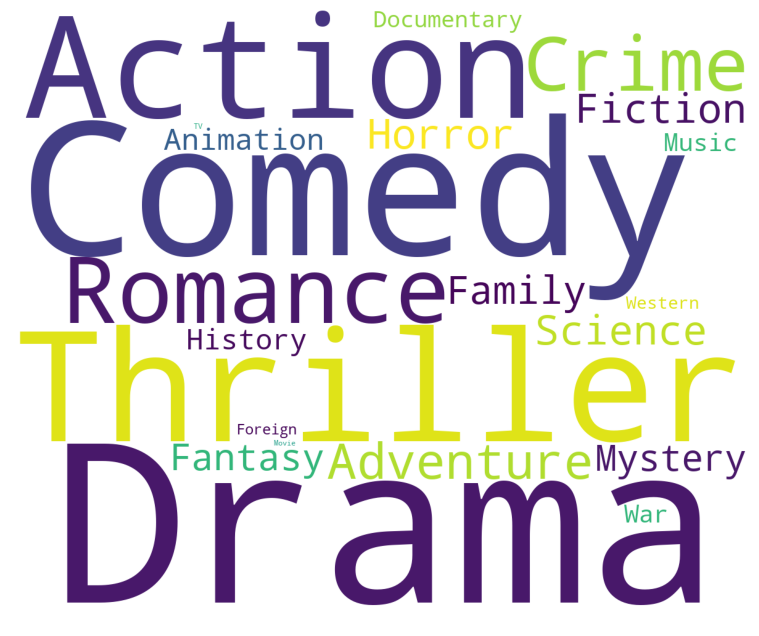

In [10]:
create_new_columns(train, 'genres', 'genres_', 15, plot=True)
create_new_columns(test, 'genres', 'genres_', 15)

3. Production Companies

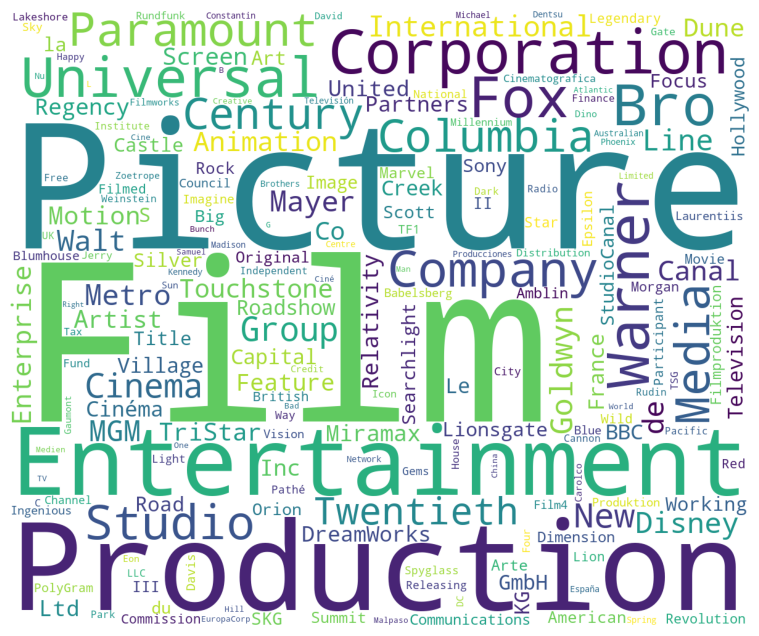

In [11]:
create_new_columns(train, 'production_companies', 'production_companies_', 15,True)
create_new_columns(test, 'production_companies', 'production_companies_', 15)

4. Production Countries

In [12]:
create_new_columns(train, 'production_countries', 'production_countries_', 15,stat=True,vals=True)
create_new_columns(test, 'production_countries', 'production_countries_', 15)

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64
United States of America        76.07
United Kingdom                  12.67
France                          7.4
Germany                         5.57
Canada                          4.0
India                           2.7
Italy                           2.13
Japan                           2.03
Australia                       2.03
Russia                          1.93
Spain                           1.8
China                           1.4
Hong Kong                       1.4
Ireland                         0.77
Belgium                         0.77


5. Spoken Language

In [13]:
create_new_columns(train, 'spoken_languages', 'spoken_languages_', 10,stat=True)
create_new_columns(test, 'spoken_languages', 'spoken_languages_', 10)

English                         87.27
Français                        9.6
Español                         7.97
Deutsch                         5.63
Pусский                         5.07
Italiano                        4.13
日本語                             2.97
普通话                             2.27
हिन्दी                          1.87
                                1.57


6. Keywords

In [14]:
create_new_columns(train, 'Keywords', 'Keywords_', 30,stat_p=True)
create_new_columns(test, 'Keywords', 'Keywords_', 30)

woman director                  175
independent film                155
duringcreditsstinger            134
murder                          123
based on novel                  111
violence                        87
sport                           82
biography                       77
aftercreditsstinger             75
dystopia                        73
revenge                         73
friendship                      72
sex                             71
suspense                        67
sequel                          66
love                            64
police                          64
teenager                        61
nudity                          57
female nudity                   53


7. Cast

In [15]:
create_new_columns(train, 'cast', 'cast_', 20,stat_p=True)
create_new_columns(test, 'cast', 'cast_', 20)

Samuel L. Jackson               30
Robert De Niro                  30
Morgan Freeman                  27
J.K. Simmons                    25
Bruce Willis                    25
Liam Neeson                     25
Susan Sarandon                  25
Bruce McGill                    24
John Turturro                   24
Forest Whitaker                 23
Willem Dafoe                    23
Bill Murray                     22
Owen Wilson                     22
Nicolas Cage                    22
Sylvester Stallone              21
Jason Statham                   21
Keith David                     21
John Goodman                    21
Mel Gibson                      21
Sigourney Weaver                21


Preprocessing the genders

In [16]:
list_of_gender = train['cast'].apply(lambda x: [i['gender'] for i in x] if x!={} else [])
print(Counter([i for j in list_of_gender for i in j]).most_common())
train['gender_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['gender_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['gender_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
test['gender_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['gender_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['gender_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

[(2, 27949), (0, 20329), (1, 13533)]


Here we are checking the gender of the cast members and creating a new column to count the number of genders in a particular movie

In [17]:
list_of_characters = train['cast'].apply(lambda x: [i['character'] for i in x] if x!={} else [])
Counter(i for j in list_of_characters for i in j).most_common(20)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44),
 ('Charlie', 41),
 ('Waiter', 41),
 ('Cop', 40),
 ('Priest', 40),
 ('Student', 39)]

In [18]:
train['num_cast_characters'] = train['cast'].apply(lambda x: len(x) if x!={} else 0)
train['all_cast_character'] = train['cast'].apply(lambda x: " ".join(i['character'] for i in x) if x!={} else "")
top_cast_characters = [m[0] for m in Counter(i for j in list_of_characters for i in j).most_common(20)]
for g in top_cast_characters:
    train['cast_character_'+g] = train['all_cast_character'].apply(lambda x: 1 if g in x else 0)

test['num_cast_characters'] = test['cast'].apply(lambda x: len(x) if x!={} else 0)
test['all_cast_character'] = test['cast'].apply(lambda x: " ".join(i['character'] for i in x) if x!={} else "")
for g in top_cast_characters:
    test['cast_character_'+g] = test['all_cast_character'].apply(lambda x: 1 if g in x else 0)

8. Crew

In [19]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [20]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x!={} else 0)
train['all_crew_name'] = train['crew'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else [])
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]

for g in top_crew_names:
    train['crew_name_' + g] = train['all_crew_name'].apply(lambda x: 1 if g in x else 0)


test['num_crew'] = test['crew'].apply(lambda x: len(x) if x!={} else 0)
test['all_crew_name'] = test['crew'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else [])

for g in top_crew_names:
    test['crew_name_' + g] = test['all_crew_name'].apply(lambda x: 1 if g in x else 0)

Preprocessing the genders

In [21]:
list_of_gender = train['crew'].apply(lambda x: [i['gender'] for i in x] if x!={} else [])
print(Counter(i for j in list_of_gender for i in j).most_common(15))
train['crew_gender_0'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
train['crew_gender_1'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 1))
train['crew_gender_2'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

test['crew_gender_0'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
test['crew_gender_1'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 1))
test['crew_gender_2'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

[(0, 41787), (2, 24898), (1, 6412)]


Similar to before we assigned total number of each gender for a particular movie

Now preprocessing the job and number of jobs for the crew

In [22]:
list_of_jobs = train['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])
Counter([i for j in list_of_jobs for i in j]).most_common(20)

train['all_job'] = train['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])
top_job = [m[0] for m in Counter([i for j in list_of_jobs for i in j]).most_common(20)]

for g in top_job:
    train['job_'+g] = train['all_job'].apply(lambda x: 1 if g in x else 0)

test['all_job'] = test['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])

for g in top_job:
    test['job_'+g] = test['all_job'].apply(lambda x: 1 if g in x else 0)

# ***Data Visualization***

In [23]:
def plots(df,column1,column2=None,column3=None,histo=False,scatter=False,boxp=False,word=False,change=False):
    if histo==True:
        fig, ax = plt.subplots(1,2, figsize=(16,6))
        plt.subplot(1,2,1)
        plt.hist(df[column1])
        plt.title((column1[0].upper())+column1[1:]+" distribution")

        plt.subplot(1, 2, 2)
        plt.hist(np.log1p(df[column1]))
        plt.title("Log1 "+ column1 +" distribution")

        plt.show()
        if change==True:
            df['log_'+column1]=np.log1p(df[column1])

    if scatter==True:
        fig, ax = plt.subplots(1,2, figsize=(16,6))
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=df[column3], y=df[column2])
        plt.xlabel(column2)
        plt.title(column2[0].upper()+column2[1:] +  " vs " + column3[0].upper()+column3[1:])

        plt.subplot(1,2,2)
        sns.scatterplot(x=column3, y=column1, data=df)
        plt.title(column1[0].upper()+column1[1:] +  " vs " + column3[0].upper()+column3[1:])

        plt.show()
    
    if boxp==True:
        plt.subplots(1,2,figsize=(16, 6))
        plt.subplot(1,2,1)
        sns.boxenplot(x=column1, y=column2, data= df.loc[df[column1].isin(df[column1].value_counts().head(10).index)] )
        plt.title(column1[0].upper()+column1[1:] +  " vs " + column2[0].upper()+column2[1:])

        plt.subplot(1,2,2)
        sns.boxenplot(x=column1, y=column3, data= df.loc[df[column1].isin(df[column1].value_counts().head(10).index)] )
        plt.title(column1[0].upper()+column1[1:] +  " vs " + column3[0].upper()+column3[1:])

        plt.show()
    if word==True:
        plt.figure(figsize=(9, 9))
        title = ' '.join(train[column1].fillna(' ').values)
        img = WordCloud(width=1000, height=1000, background_color='white').generate(title)
        plt.title(column1[0].upper()+column1[1:]+" wordcloud")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

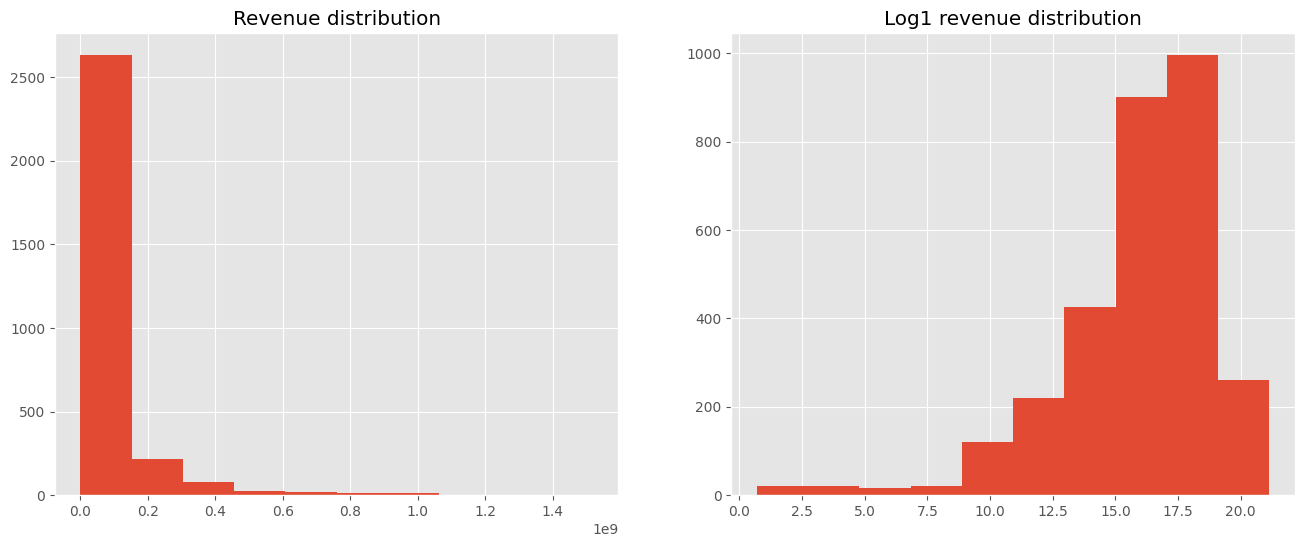

In [24]:
plots(train,'revenue',histo=True,change=True)

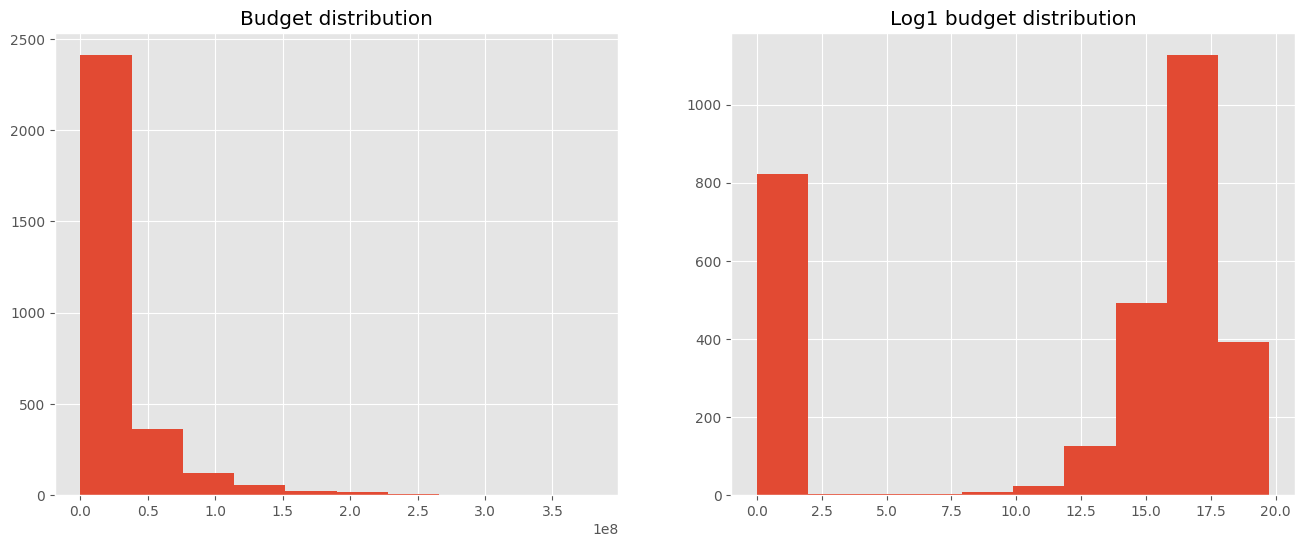

In [25]:
plots(train,'budget',histo=True,change=True)

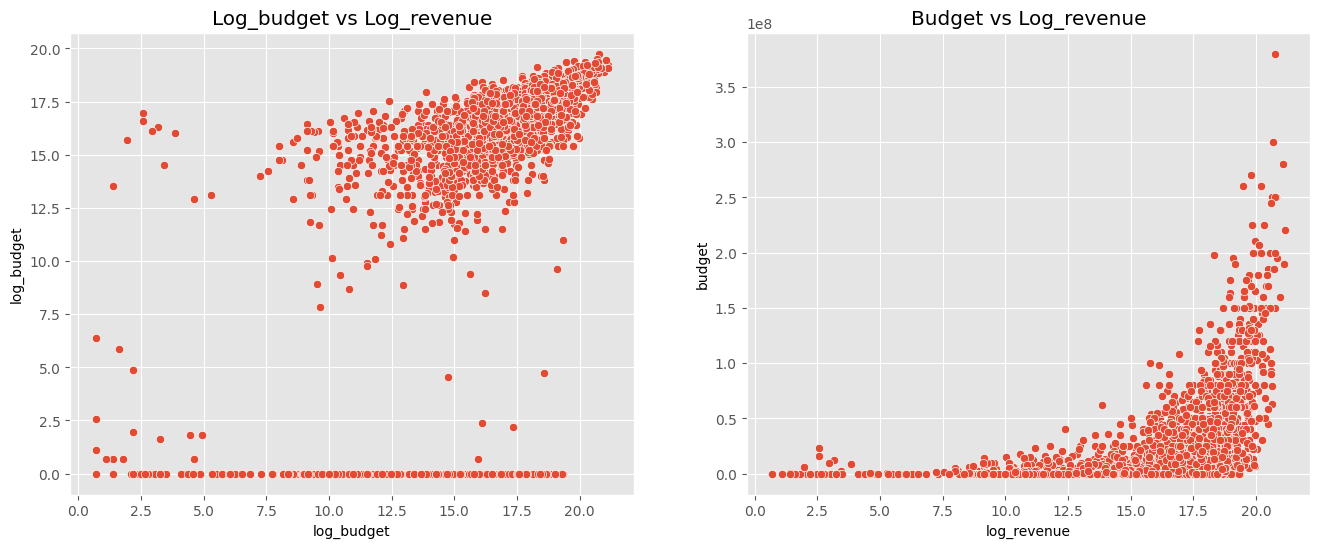

In [26]:
plots(train,'budget','log_budget','log_revenue',scatter=True)

In [27]:
test['log_budget'] = np.log1p(test['budget'])

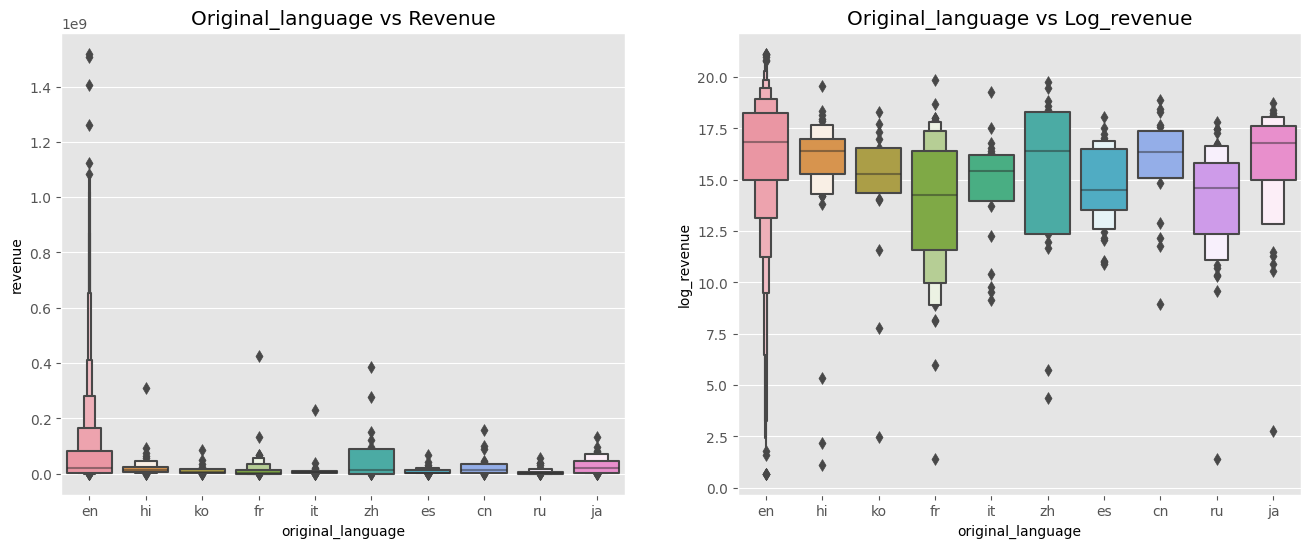

In [28]:
plots(train,'original_language','revenue','log_revenue',boxp=True)

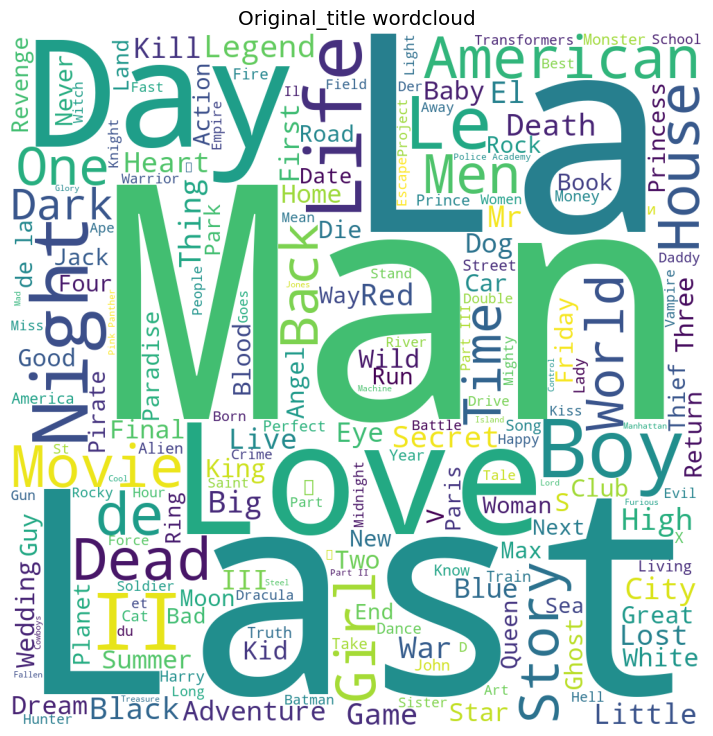

In [29]:
plots(train,'original_title',word=True)

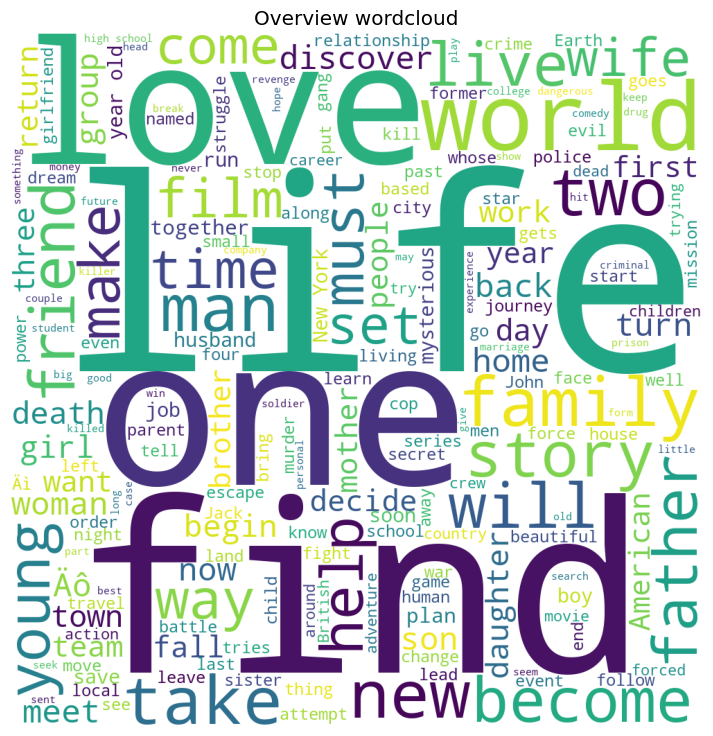

In [30]:
plots(train,'overview',word=True)

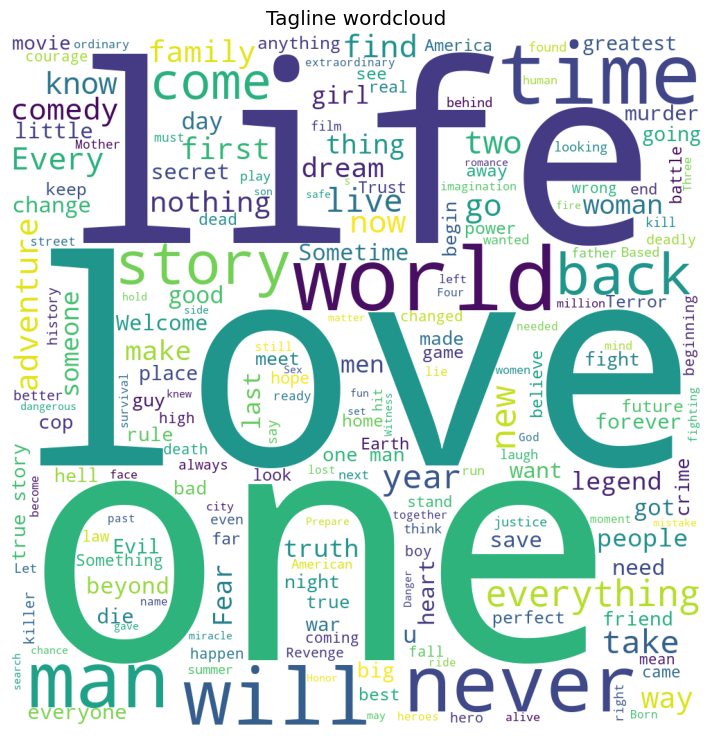

In [31]:
plots(train,'tagline',word=True)

We are now checking the impact of words on revenue

In [32]:
tfidf = TfidfVectorizer()

x = tfidf.fit_transform(train['overview'].fillna(''))
y = train['log_revenue']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(mean_squared_error(lr.predict(X_valid), y_valid), mean_absolute_error(lr.predict(X_valid), y_valid))


print("Target value : ", train['log_revenue'][500])

prediction = lr.predict(tfidf.transform([train['overview'].values[500]]))[0]
print("Prediction : ",prediction)

11.621197093130089 2.594451488210046
Target value :  13.516790456663609
Prediction :  13.516791226520683


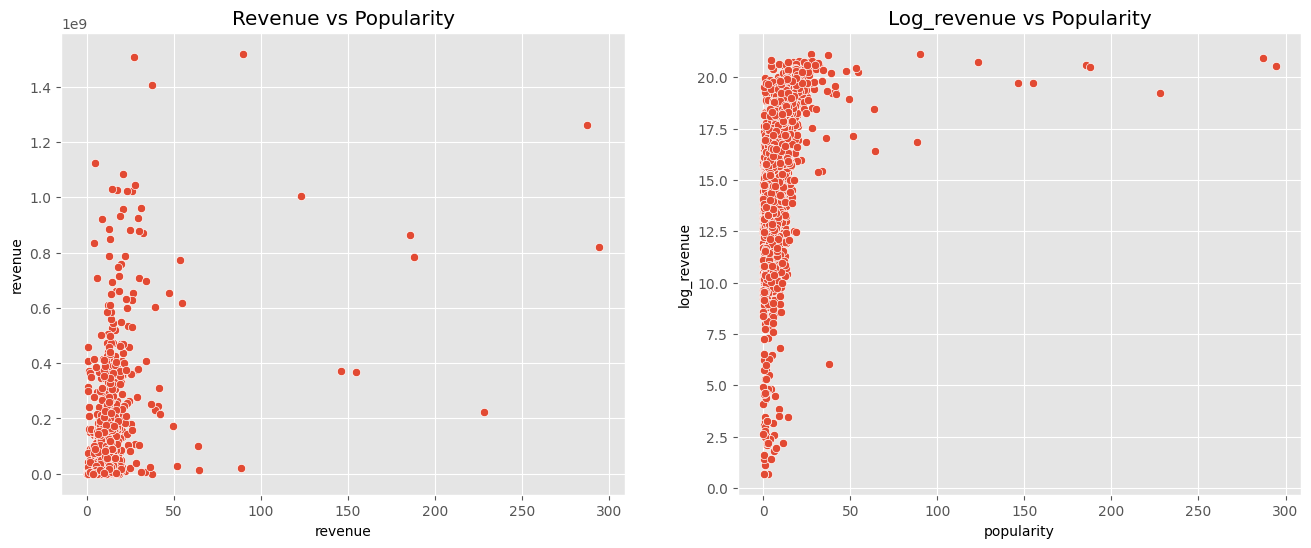

In [33]:
plots(train,'log_revenue','revenue','popularity',scatter=True)

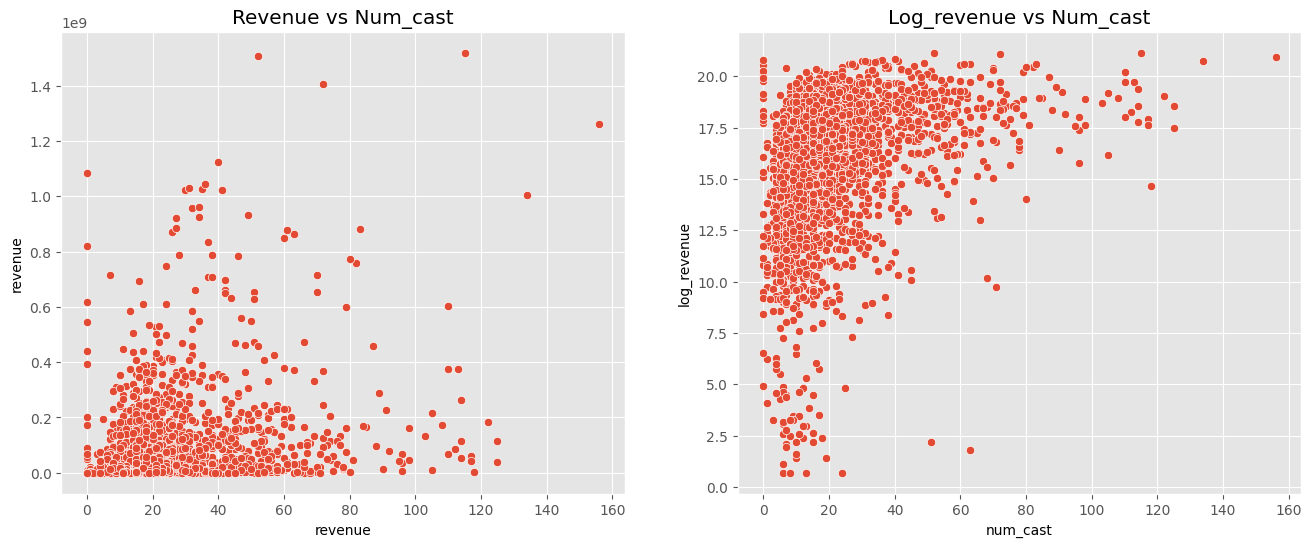

In [34]:
plots(train,'log_revenue','revenue','num_cast',scatter=True)

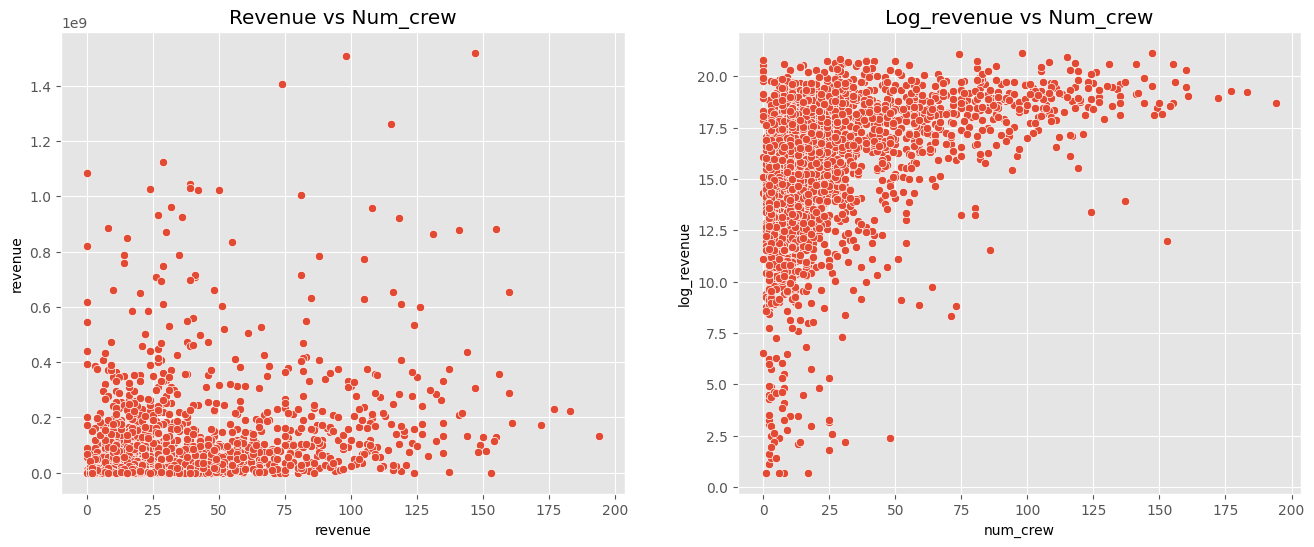

In [35]:
plots(train,'log_revenue','revenue','num_crew',scatter=True)

In [36]:
test[test.release_date.isnull()].index
test.at[828, 'release_date'] = '1/5/2000'

train['release_date_year'] = train['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))
test['release_date_year'] = test['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))

train['release_date_month'] = pd.to_datetime(train['release_date']).dt.month
test['release_date_month'] = pd.to_datetime(test['release_date']).dt.month

train['release_date_weekday'] = pd.to_datetime(train['release_date']).dt.weekday
test['release_date_weekday'] = pd.to_datetime(test['release_date']).dt.weekday

train['release_date_weekofyear'] = pd.to_datetime(train['release_date']).dt.weekofyear
test['release_date_weekofyear'] = pd.to_datetime(test['release_date']).dt.weekofyear

train['release_date_day'] = pd.to_datetime(train['release_date']).dt.day
test['release_date_day'] = pd.to_datetime(test['release_date']).dt.day

In [37]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

data = [go.Scatter(x = d1.index, y=d1.values, name='train'), go.Scatter(x = d2.index, y = d2.values, name='test')]
layout = go.Layout(dict(title="Number of movies per year",
                  xaxis = dict(title="year"),
                  yaxis = dict(title="Count")),legend = dict(orientation='v'))
py.iplot(dict(data = data, layout=layout))

In [38]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby('release_date_year')['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [39]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

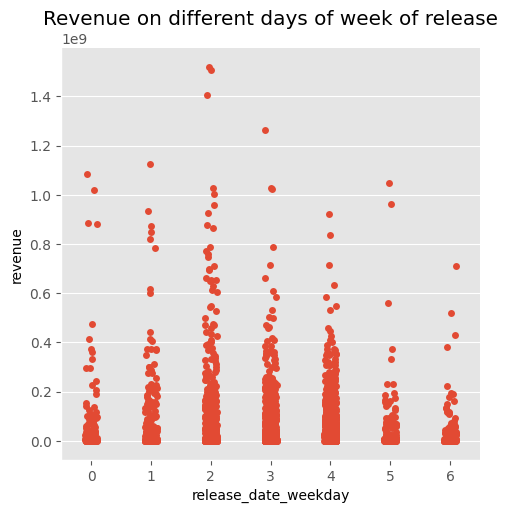

In [40]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

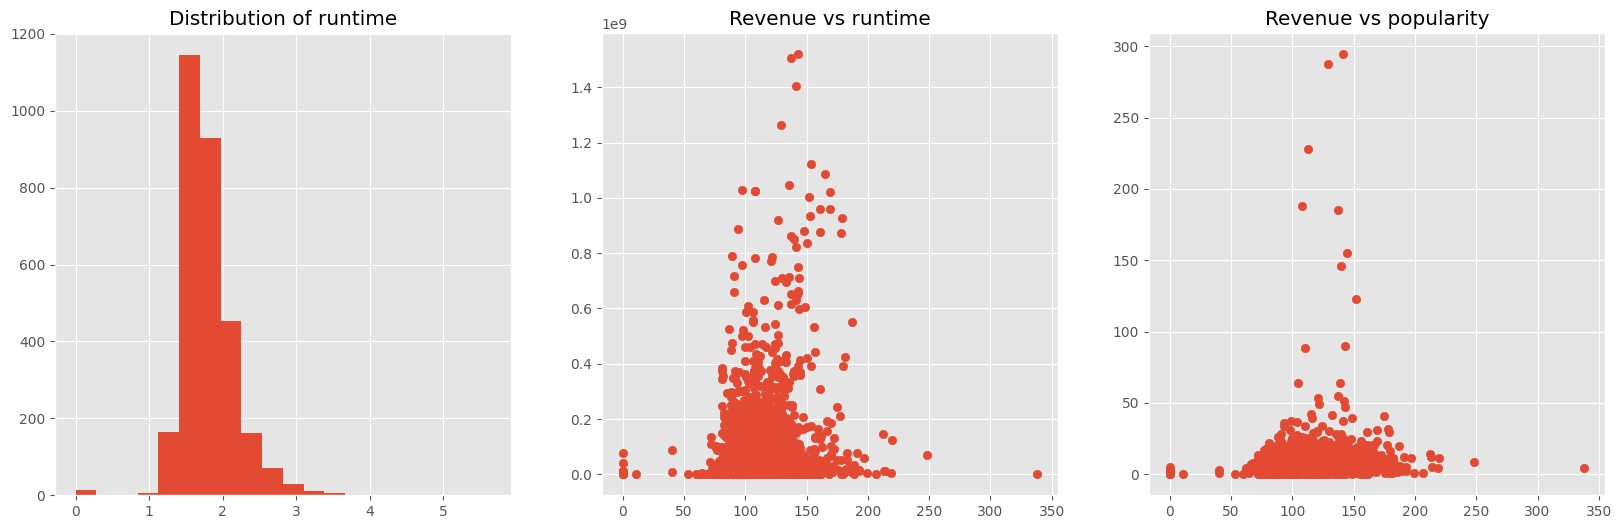

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

plt.subplot(1,3,1)
plt.hist(train['runtime'].fillna(0)/60, bins=20)
plt.title("Distribution of runtime")

plt.subplot(1,3,2)
plt.scatter(x = 'runtime', y='revenue', data=train)
plt.title("Revenue vs runtime")

plt.subplot(1,3,3)
plt.scatter(x = 'runtime', y='popularity', data=train)
plt.title("Revenue vs popularity")

plt.show()

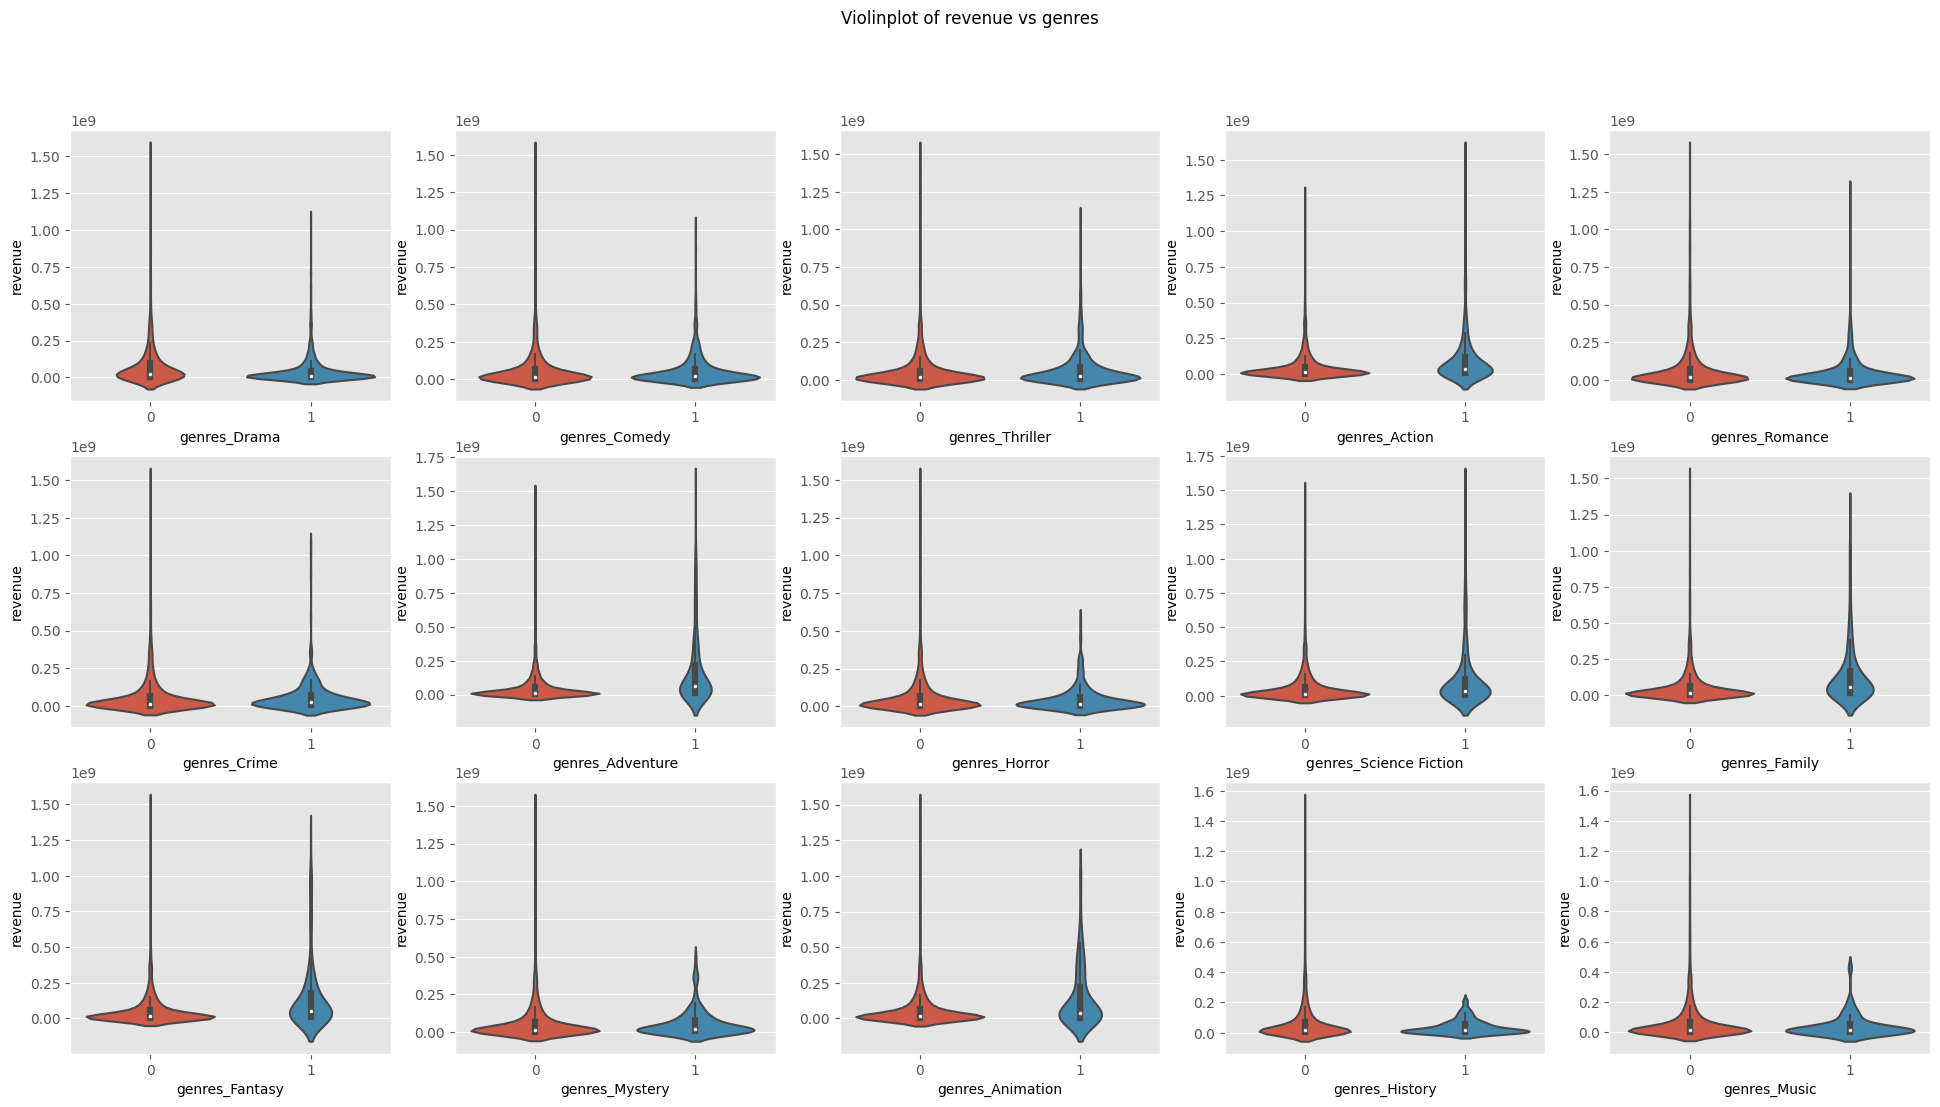

In [42]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genres_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

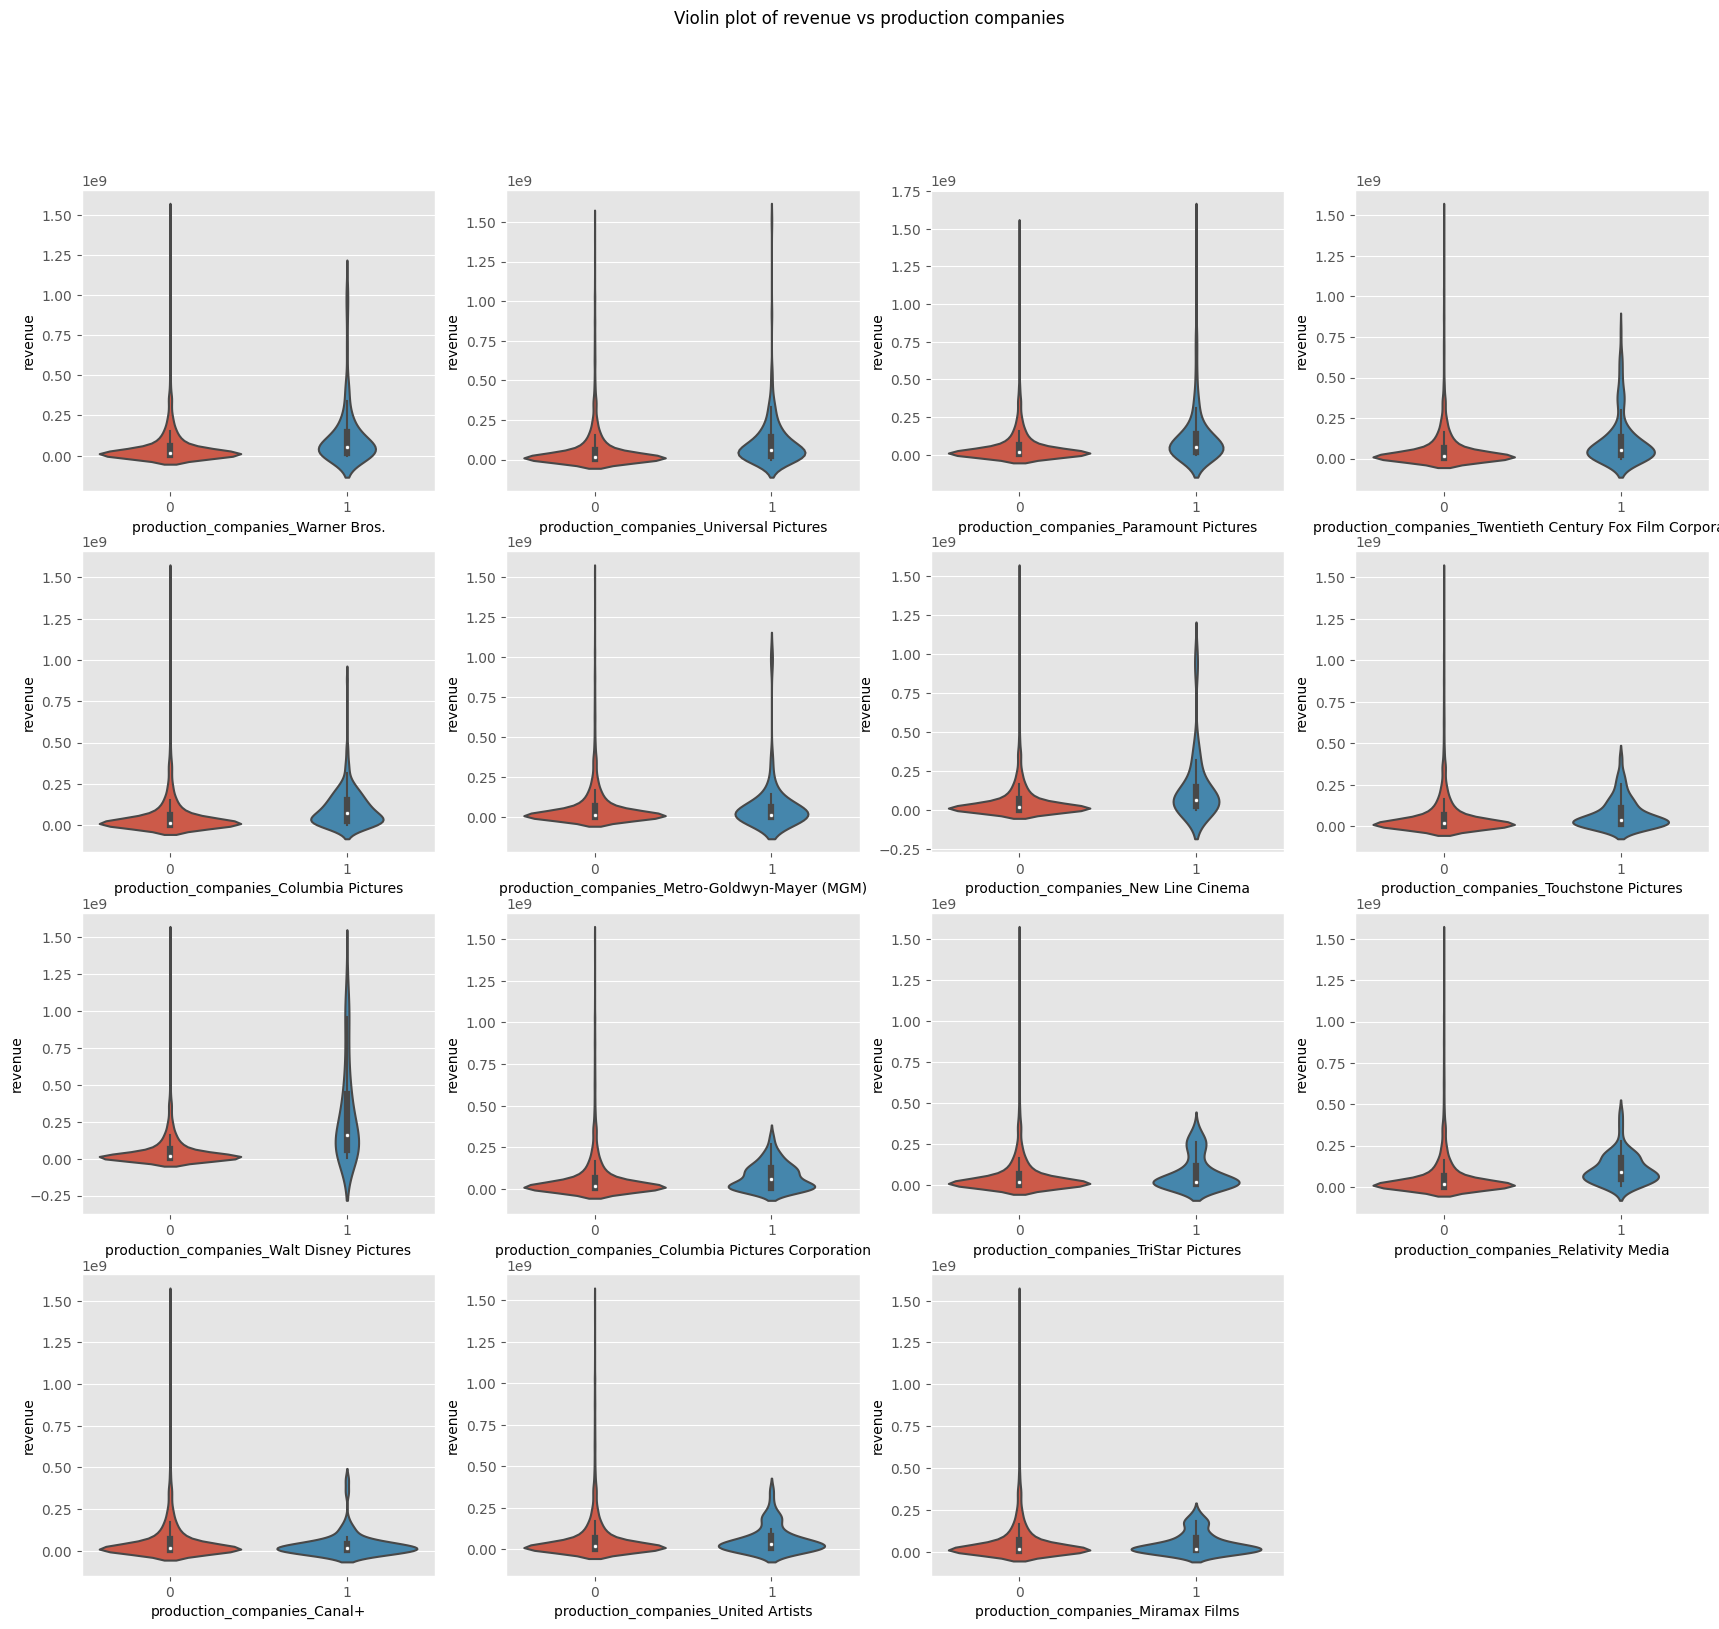

In [43]:
fig, ax = plt.subplots(4, 4, figsize=(21, 18))
#fig.tight_layout()
#plt.subplots_adjust(wspace=None, hspace=None)
plt.axis('off')
plt.suptitle("Violin plot of revenue vs production companies")
for i,e in enumerate([col for col in train.columns if 'production_companies_' in col]):
    sns.violinplot(x = e, y='revenue', data = train, ax = ax[i // 4][i % 4])

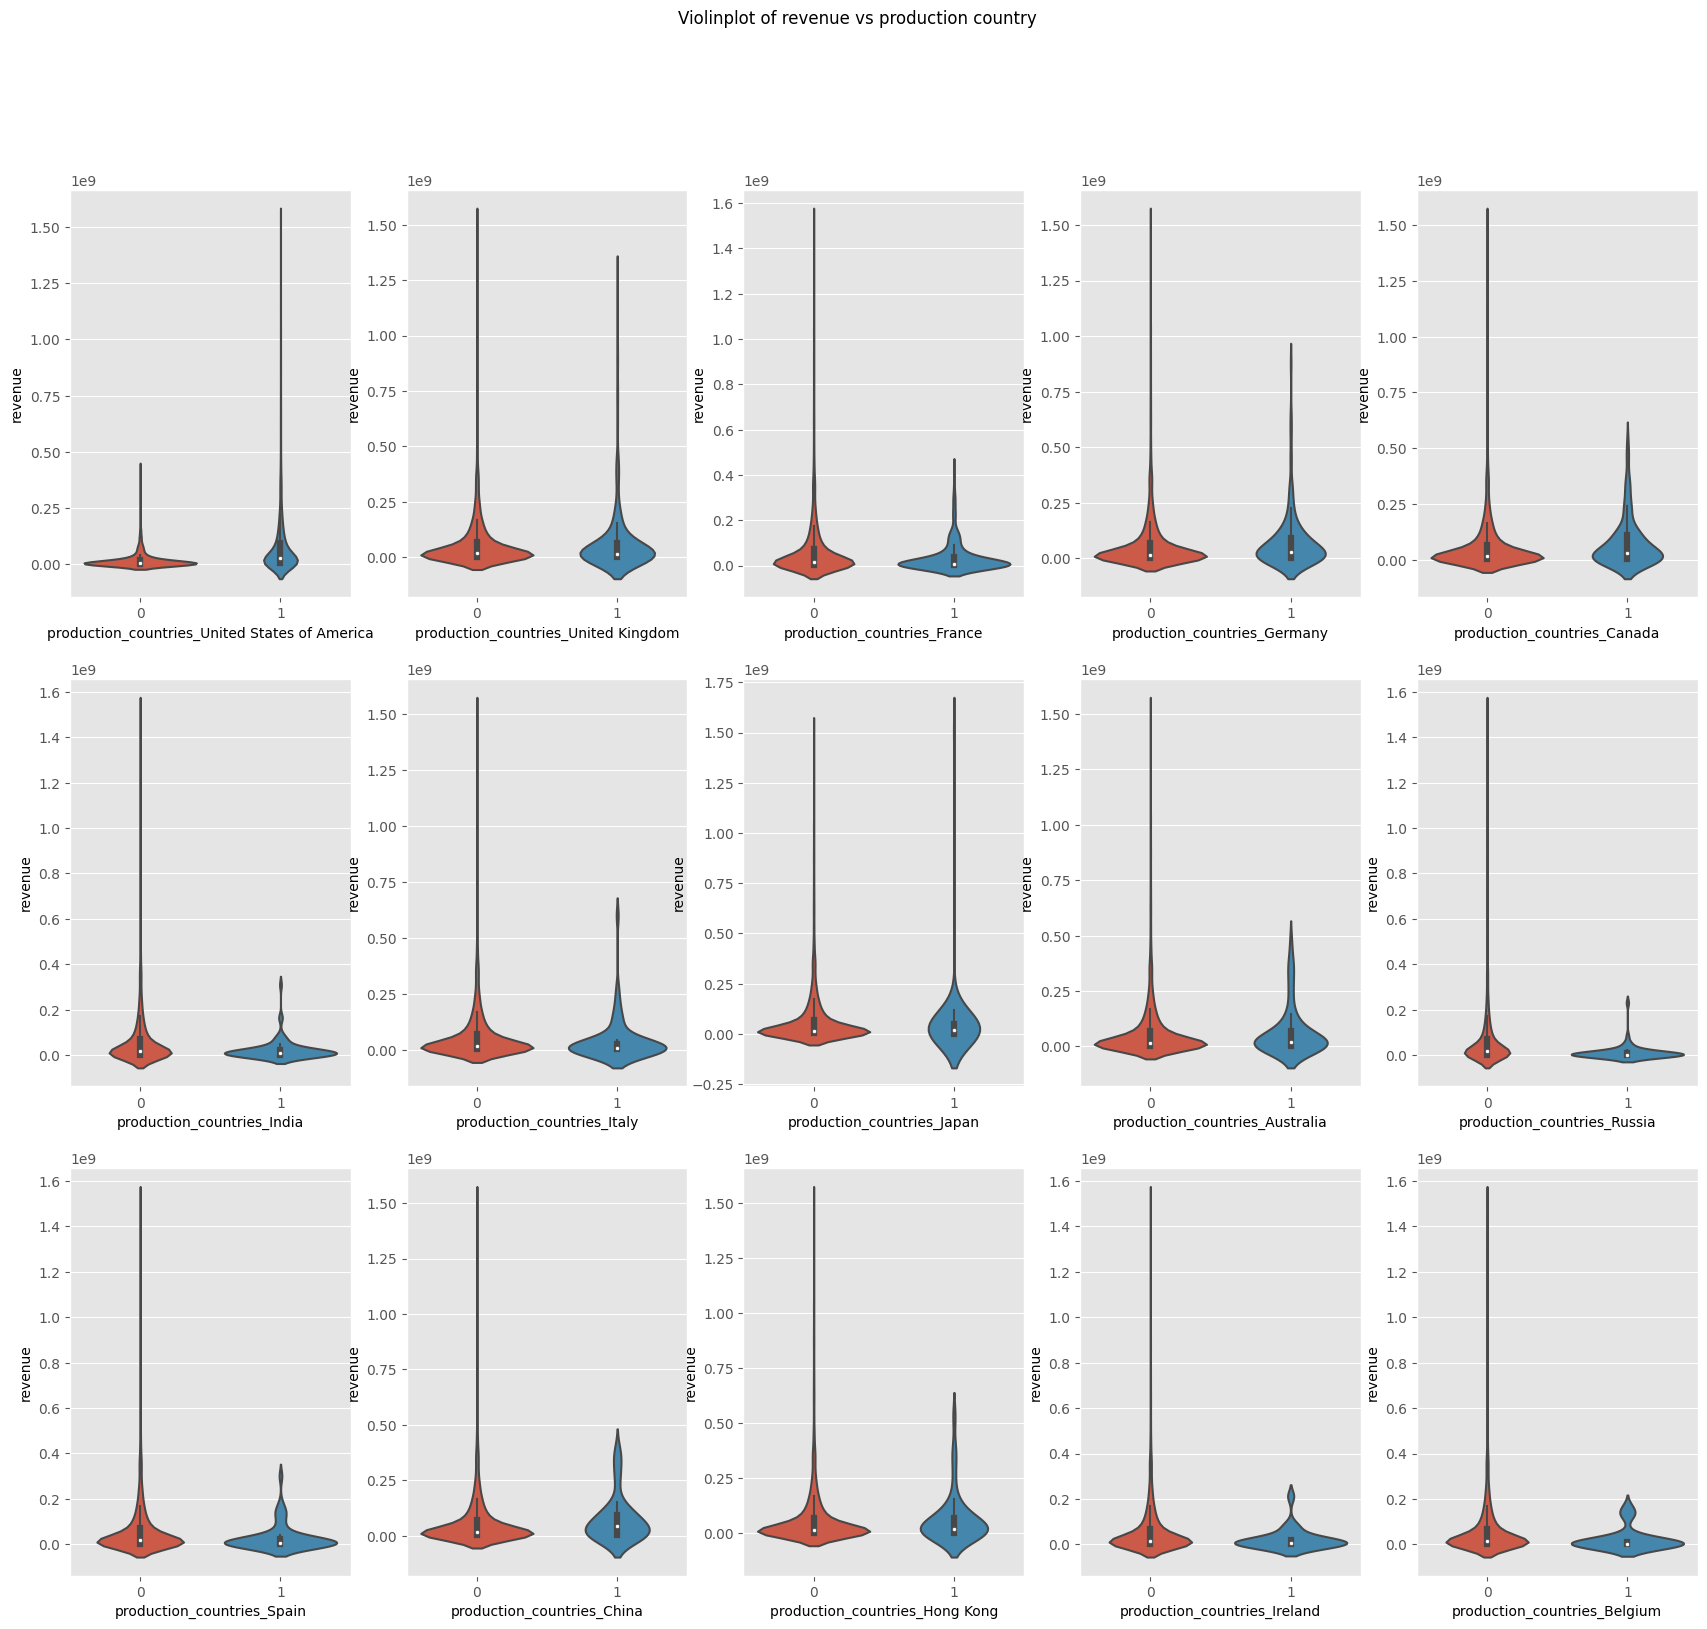

In [44]:
f, axes = plt.subplots(3, 5, figsize=(21, 18))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_countries_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i %5]);

#### Deleting unnecessary columns and label encoding

In [45]:
train.drop(['genres', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries','release_date', 'spoken_languages','status', 'Keywords','cast','crew', 'id'], axis=1, inplace=True)
test.drop(['genres', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries','release_date', 'spoken_languages','status', 'Keywords','cast','crew', 'id'], axis=1, inplace=True)

In [46]:
train['collection'] = train['collection'].apply(lambda x: str(x))
test['collection'] = test['collection'].apply(lambda x: str(x))

In [47]:
for col in ['original_language', 'all_genres', 'collection']:
    lb = LabelEncoder()
    lb.fit(list(train[col].fillna("")) + list(test[col].fillna("")))
    train[col] = lb.transform(train[col].fillna(""))
    test[col] = lb.transform(test[col].fillna(""))

In [48]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [49]:
train.drop(['all_production_companies', 'all_production_countries', 'all_spoken_languages', 'all_Keywords', 'all_cast', 'all_cast_character', 'all_crew_name', 'all_job'], axis=1, inplace=True)
test.drop(['all_production_companies', 'all_production_countries', 'all_spoken_languages', 'all_Keywords', 'all_cast', 'all_cast_character', 'all_crew_name', 'all_job'], axis=1, inplace=True)

In [50]:
print("Columns that are not in test but in train")
for col in train.columns:
    if col not in test.columns:
        print(col)
        if col!='revenue' and col!='log_revenue':
            train.drop(col, axis=1, inplace=True)

Columns that are not in test but in train
revenue
Keywords_father son relationship
Keywords_kidnapping
Keywords_investigation
cast_J.K. Simmons
cast_Susan Sarandon
cast_Bruce McGill
cast_John Turturro
cast_Forest Whitaker
cast_Bill Murray
cast_Owen Wilson
cast_Jason Statham
cast_Keith David
cast_John Goodman
cast_Mel Gibson
cast_Sigourney Weaver
log_revenue


In [51]:
train.drop(['budget'], axis=1, inplace=True)
test.drop(['budget'], axis=1, inplace=True)
train['runtime'].fillna(train['runtime'].mean(), inplace=True)
for col in train.columns:
    if(train[col].var() == 0):
        print(col)
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

spoken_languages_
cast_character_


In [52]:
X = train.drop(['log_revenue', 'revenue'], axis=1)
Y = train['log_revenue']

In [53]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state = 42)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((2700, 177), (300, 177), (2700,), (300,))

# ***Ml Algorithms***

In [54]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
mean_squared_error(lr.predict(X_valid), Y_valid), mean_absolute_error(lr.predict(X_valid), Y_valid)

(5.393283308946936, 1.5485039727239085)

In [55]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
mean_squared_error(rf.predict(X_valid), Y_valid), mean_absolute_error(rf.predict(X_valid), Y_valid)

(4.574708473419041, 1.356243309374928)

<Axes: >

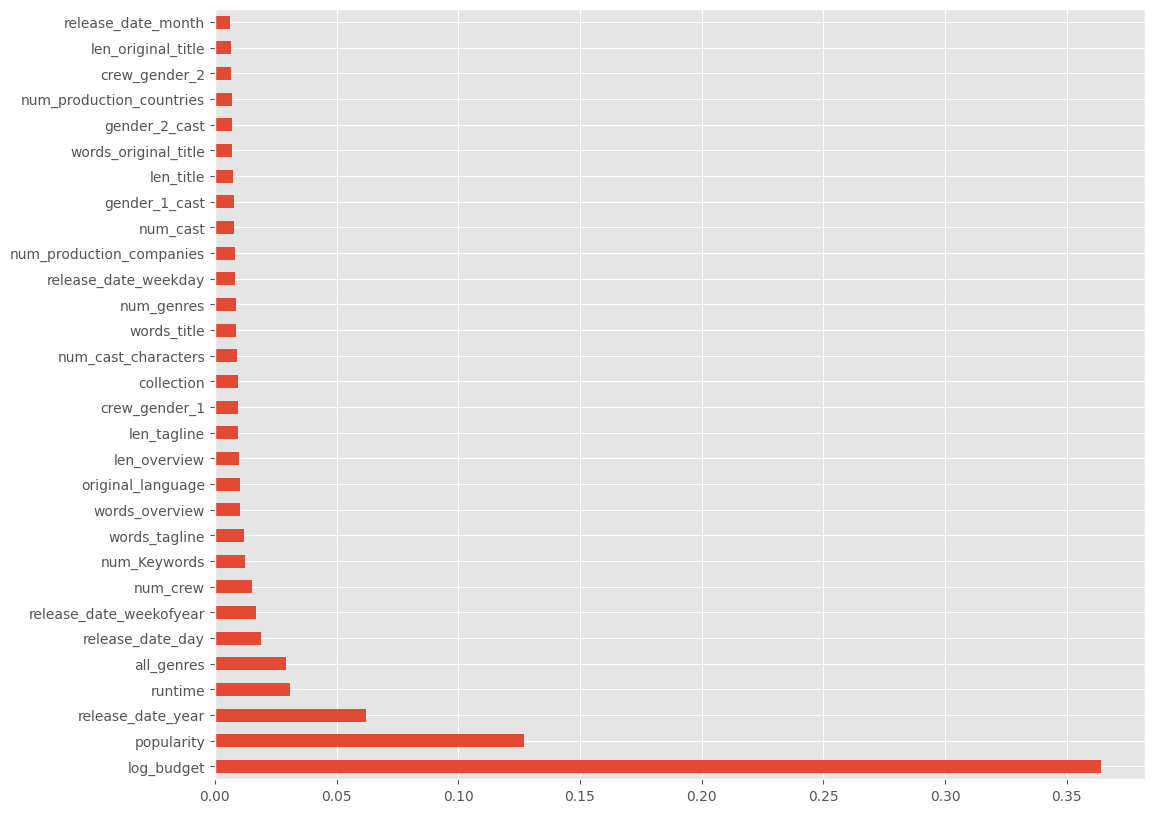

In [56]:
ax = plt.figure(figsize=(12, 10))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [57]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
mean_squared_error(reg.predict(X_valid), Y_valid), mean_absolute_error(reg.predict(X_valid), Y_valid)

(9.641037538035597, 2.3252371264428287)

In [58]:
xgb = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 1.475 (0.095)


In [59]:
model = Sequential()
model.add(Dense(177, input_shape = (177, ), kernel_initializer = 'normal', activation='elu'))
model.add(Normalization())
model.add(Dense(396, kernel_initializer = 'normal', activation='elu'))
model.add(Normalization())
model.add(Dense(1028, kernel_initializer = 'normal', activation='elu'))
model.add(Dense(396, kernel_initializer = 'normal', activation='elu'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 177)               31506     
                                                                 
 normalization (Normalizatio  (None, 177)              355       
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 396)               70488     
                                                                 
 normalization_1 (Normalizat  (None, 396)              793       
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 1028)              408116    
                                                                 
 dense_3 (Dense)             (None, 396)               4

In [60]:
history = model.fit(X, Y, batch_size=20, epochs = 40, validation_split=0.1)
history

Epoch 1/40
135/135 [==============================] - 4s 15ms/step - loss: 7.8751 - val_loss: 2.1171
Epoch 2/40
135/135 [==============================] - 2s 12ms/step - loss: 2.0551 - val_loss: 1.7453
Epoch 3/40
135/135 [==============================] - 2s 12ms/step - loss: 1.9334 - val_loss: 1.6487
Epoch 4/40
135/135 [==============================] - 2s 15ms/step - loss: 1.9364 - val_loss: 1.9219
Epoch 5/40
135/135 [==============================] - 2s 13ms/step - loss: 1.7607 - val_loss: 1.5194
Epoch 6/40
135/135 [==============================] - 2s 13ms/step - loss: 1.7422 - val_loss: 1.7294
Epoch 7/40
135/135 [==============================] - 2s 16ms/step - loss: 1.7735 - val_loss: 1.5387
Epoch 8/40
135/135 [==============================] - 2s 13ms/step - loss: 1.7557 - val_loss: 1.5325
Epoch 9/40
135/135 [==============================] - 2s 14ms/step - loss: 1.6369 - val_loss: 1.5207
Epoch 10/40
135/135 [==============================] - 2s 16ms/step - loss: 1.6789 - val_lo

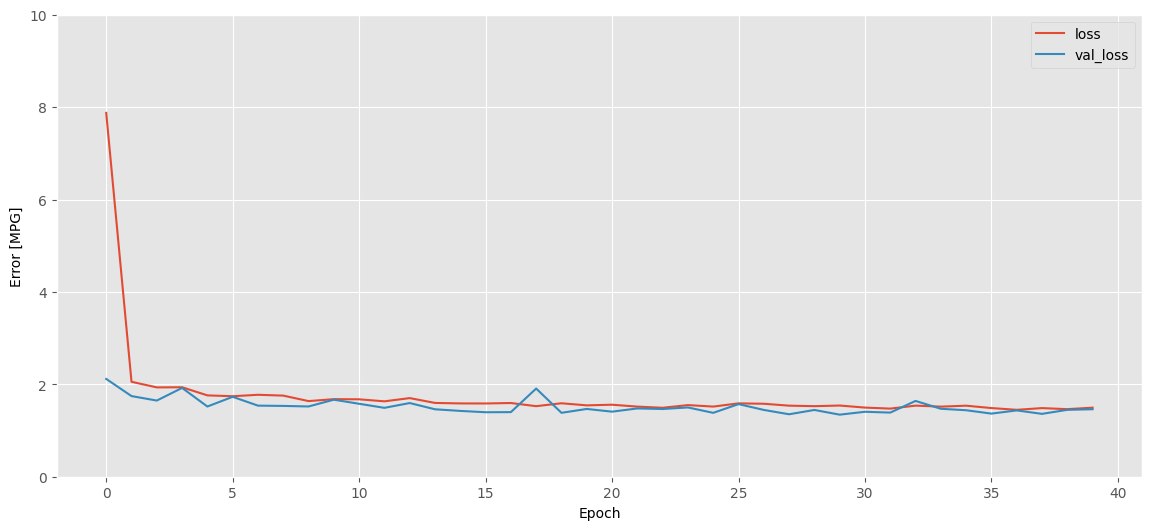

In [61]:
def plot_loss(history):
  plt.figure(figsize=(14, 6))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)